<img src='logo.png' width="600px"/>

# Background

   Since Riot Games launched "League of Legends" in 2009, it has grown to become the most popular game in the world, boasting an average of over 27 million players online per day. The game revolves around a total of ten players per match, pit against one another in two teams of five. Each of these players are given a choice of 129 unique champions to play as. 
   Due to the competitive nature of the game, each player is given a rank ranging from bronze to challenger, determined by their ratio of wins to losses. The goal of this report is to analyze trends in how a champion specialization affects player ranking and to determine if there is any correlation between the different champions played.

# Getting the Data

To acquire the data, I need to make a request from Riot's API using my own unique API Key

In [1]:
myKey = "6aacc2fb-5fb7-4b4e-8250-e5005b85e22b"

In [2]:
import glob
import json
import requests

My initial goal is to get the ranking and champion usage from a random sample of players. However, player Ids are random longs with no immediately recognizable pattern. Luckily, Riot releases and random sample of 1,000 matches in the form of JSON files. Each match, contains 10 players so that gives me a sample of 10,000 players to start with. But first I have to extract them from the matches...

In [3]:
matchFiles = glob.glob("/data/andyl7an/*")
summonerIDs = []
platformIDs = []

for file in matchFiles:
    if (file == '/data/andyl7an/champData' or file == '/data/andyl7an/champData27'):
        continue
    with open(file, encoding = "ISO-8859-1") as data_file:    
        data = json.load(data_file)
        for i in range(len(data['matches'])):
            for j in range(len(data['matches'][0]['participantIdentities'])):
                summonerIDs.append(data['matches'][i]['participantIdentities'][j]['player']['summonerId'])
                platformIDs.append(data['matches'][i]['platformId'])

In [4]:
assert(len(summonerIDs) == 10000)

Now that I have all 10,000 player Ids, I can use the API to get data from each of these players. Here are the methods I've used to filter out information from my API calls. 

In [5]:
myId = 28520860

A method to parse the player's tier, this can be anywhere between bronze to challenger

In [6]:
def getRank(id):
    
    url = "https://na.api.pvp.net/api/lol/na/v2.5/league/by-summoner/"
    url = url + str(id) 
    url = url + "?api_key=" + myKey
    output = requests.get(url)
    
    output = output.json()
    tempList = output[str(id)]
    length = len(tempList) - 1
    x = tempList[length]['tier']
    return x

In [7]:
assert(getRank(myId) == 'PLATINUM')

A method that returns a boolean to determine if the player is specialized. I will set this to true if the player's games with their most played champion outnumber both their second and third most played games combined.

In [8]:
def isOTP(id):
    url = "https://na.api.pvp.net/championmastery/location/NA1/player/"
    url = url + str(id)
    url = url + "/topchampions?api_key=" + myKey
    output = requests.get(url)
    output = output.json()
    points1 = output[0]['championPoints']
    points2 = output[1]['championPoints']
    points3 = output[2]['championPoints']
    if (points1 > (points2 + points3)):
        return True
    else:
        return False

In [9]:
assert(isOTP(myId) == True)

A method to parse the division of a player to complement their tier. For example a bronze-tier player could be anywhere between bronze 5 to bronze 1.

In [10]:
def getDiv(id):
    url = "https://na.api.pvp.net/api/lol/na/v2.5/league/by-summoner/"
    url = url + str(id)
    url = url + "/entry?api_key=" + myKey
    output = requests.get(url).json()
    return output[str(id)][0]['entries'][0]['division']

In [11]:
assert(getDiv(myId) == 'II')

This returns me an overview of the amount the player has played every champion in the game.

In [12]:
def champUsage(id):
    url = "https://na.api.pvp.net/championmastery/location/NA1/player/"
    url = url + str(id)
    url = url + "/champions?api_key=" + myKey
    output = requests.get(url)
    output = output.json()
    return output

In [13]:
champUsage(myId)

[{'championId': 27,
  'championLevel': 5,
  'championPoints': 202543,
  'championPointsSinceLastLevel': 180943,
  'championPointsUntilNextLevel': 0,
  'chestGranted': True,
  'highestGrade': 'S',
  'lastPlayTime': 1460060929000,
  'playerId': 28520860},
 {'championId': 126,
  'championLevel': 5,
  'championPoints': 21918,
  'championPointsSinceLastLevel': 318,
  'championPointsUntilNextLevel': 0,
  'chestGranted': False,
  'lastPlayTime': 1455269768000,
  'playerId': 28520860},
 {'championId': 150,
  'championLevel': 4,
  'championPoints': 19106,
  'championPointsSinceLastLevel': 6506,
  'championPointsUntilNextLevel': 2494,
  'chestGranted': True,
  'highestGrade': 'S-',
  'lastPlayTime': 1459408674000,
  'playerId': 28520860},
 {'championId': 75,
  'championLevel': 4,
  'championPoints': 14725,
  'championPointsSinceLastLevel': 2125,
  'championPointsUntilNextLevel': 6875,
  'chestGranted': False,
  'lastPlayTime': 1449211767000,
  'playerId': 28520860},
 {'championId': 8,
  'champio

Since champions are returned as champion ids, I'll need a method to convert the id to a name.

In [14]:
def getChampName(id):
    url = 'https://global.api.pvp.net/api/lol/static-data/na/v1.2/champion/'
    url = url + str(id)
    url = url + '?api_key=' + myKey
    output = requests.get(url).json()
    return output['name']

In [15]:
getChampName(27)

'Singed'

After using these API calls for each summoner ID, I've written all of this data in the form of organized text files.

# Cleaning the Data

First, I have to open the my data on Ranks and whether the player is specialized. I've written my API methods in a way so that I've already cleaned the data beforehand so this part is pretty straightforward.

In [16]:
import pandas as pd

In [17]:
rankInfo = []
with open('otpRankData.txt') as f:
    for line in f:
        line = line.split(',')
        line[1] = line[1].rstrip('\n')
        rankInfo.append(line)

In [18]:
df = pd.DataFrame(rankInfo, columns = ('Rank','Specialized'))
df.head()

,Rank,Specialized
0,BRONZEIII,False
1,BRONZEII,False
2,SILVERIV,True
3,SILVERV,True
4,BRONZEIV,False


Next, I'll open my data on champion correlations, it is currently in the form of "Champion Points". The more a player plays a specific champion, the more champion points they will have on that champion.

In [19]:
import os
import ntpath

In [20]:
champions = []
path = os.getcwd() + '/champData/'
champions =glob.glob(path+ '*')
champDict= {}

for champ in champions:
    with open(champ) as f:
        c = ntpath.basename(champ)
        for line in f:
            line = line.split(':')
            line[1] = line[1].rstrip('\n')

            champName = line[0]
            champPoints = line[1]

            champPoints = ''.join(x for x in champPoints if x.isdigit())

            if c not in champDict:
                champDict[c] = {}

            if champName not in champDict[c]:
                champDict[c][champName] = float(champPoints)
            else:
                champDict[c][champName] = float(champDict[c][champName]) + float(champPoints)
df2 = pd.DataFrame.from_dict(champDict)

In [21]:
df2.head()

,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Ashe,Azir,Bard,...,Wukong,Xerath,Xin Zhao,Yasuo,Yorick,Zac,Zed,Ziggs,Zilean,Zyra
Aatrox,NaN,141865,175222,121311,60303,8031,188719,203778,165930,91028,...,290766,1971,391843,1266608,126,233611,803127,1911,12267,34368
Ahri,204575,NaN,422634,335787,314462,520824,976585,1136145,1178885,436537,...,641234,196745,413333,4764586,172,123037,3598605,30022,178666,92412
Akali,258674,623777,NaN,88322,123126,49044,232989,278620,151434,128332,...,362816,1826,239946,1919385,NaN,37368,1021409,1664,22456,21550
Alistar,233420,639283,133159,NaN,203671,250478,573825,563427,327839,1131532,...,445583,30560,369255,2477631,4069,190482,1567386,21887,399522,103557
Amumu,108844,651704,96152,340439,NaN,244801,836233,1049864,240691,317422,...,691064,52284,622146,1542270,9095,88202,855908,63350,258294,189363


In [22]:
champColumns = list(df2.columns.values)
champIndices = list(df2.index.values)

So first, I have to convert these champion points to something more understandable. I've decided to take the maximum number of points for each champion and divide every other number in the column by that number to show the correlation. 

In [23]:
maxNum = df2.max()
i = 0
for col in champColumns:
    df2[col] = df2[col] / maxNum[i]
    i = i + 1

In [24]:
df2.head()

,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Ashe,Azir,Bard,...,Wukong,Xerath,Xin Zhao,Yasuo,Yorick,Zac,Zed,Ziggs,Zilean,Zyra
Aatrox,NaN,0.040273,0.211607,0.052334,0.050813,0.012545,0.102002,0.069108,0.073693,0.030369,...,0.186873,0.004662,0.147392,0.080139,0.001322,0.462667,0.062384,0.007071,0.030704,0.056728
Ahri,0.357209,NaN,0.510394,0.144860,0.264975,0.813533,0.527843,0.385303,0.523567,0.145641,...,0.412117,0.465311,0.155476,0.301458,0.001805,0.243675,0.279528,0.111082,0.447199,0.152535
Akali,0.451671,0.177080,NaN,0.038103,0.103749,0.076607,0.125930,0.094489,0.067255,0.042815,...,0.233180,0.004319,0.090256,0.121441,NaN,0.074007,0.079340,0.006157,0.056207,0.035570
Alistar,0.407575,0.181482,0.160810,NaN,0.171619,0.391250,0.310152,0.191076,0.145600,0.377510,...,0.286373,0.072276,0.138896,0.156761,0.042698,0.377250,0.121749,0.080982,1.000000,0.170931
Amumu,0.190053,0.185008,0.116118,0.146867,NaN,0.382382,0.451983,0.356042,0.106896,0.105901,...,0.444143,0.123654,0.234021,0.097580,0.095438,0.174684,0.066484,0.234396,0.646508,0.312563


# Exploring the Data

In [25]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

Now, I want to model some of my hypothesized trends. My first assumption is that specialized players are higher ranked than non-specialized players. This is a common belief amongst the player base.

First, here's a countplot of the ranks of the entire sample.

In [26]:
rankOrder = ['BRONZEV','BRONZEIV','BRONZEIII','BRONZEII','BRONZEI',
             'SILVERV','SILVERIV','SILVERIII','SILVERII','SILVERI',
            'GOLDV','GOLDIV','GOLDIII','GOLDII','GOLDI',
            'PLATINUMV','PLATINUMIV','PLATINUMIII','PLATINUMII','PLATINUMI',
            'DIAMONDV','DIAMONDIV','DIAMONDIII','DIAMONDII','DIAMONDI',
             'MASTERI','CHALLENGERI'
            ]

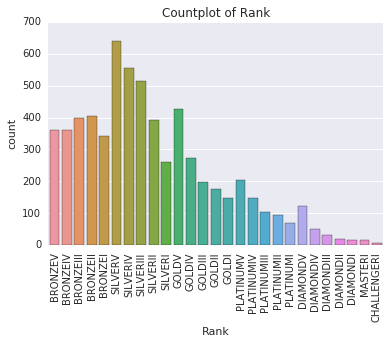

In [27]:
g = sns.countplot(df['Rank'], order = rankOrder)
g.set_xticklabels(labels = rankOrder, rotation=90);

plt.title('Countplot of Rank');

To make it easier to tell where the players ranks are distributed, I'll write a method of convert the counts to frequencies.

In [28]:
def getFreq(input):
    counts = input.value_counts()
    length = len(input)
    array = []
    for i in rankOrder:
        array.append(counts[i] / length)
    temp = range(len(rankOrder))
    plt.plot(temp, array)

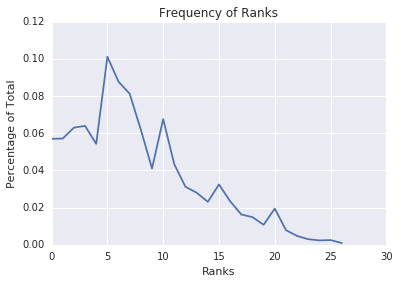

In [29]:
getFreq(df['Rank'])
plt.title('Frequency of Ranks');
plt.xlabel('Ranks')
plt.ylabel('Percentage of Total');

Now, I'll seperate the specialized and non specialized players from each other.

In [30]:
grouped = df.groupby('Specialized')
g = grouped.Rank
notOTP = g.groups['False']
isOTP = g.groups['True']
otpRanks = df['Rank'][isOTP]
nonOtpRanks = df['Rank'][notOTP]

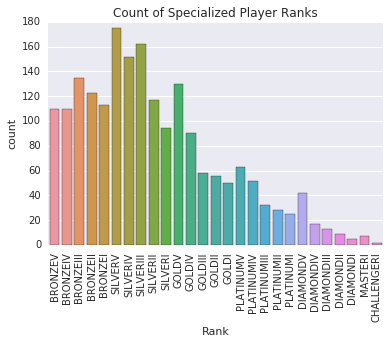

In [31]:
g = sns.countplot(otpRanks, order = rankOrder)
g.set_xticklabels(labels = rankOrder, rotation=90);
plt.title('Count of Specialized Player Ranks');

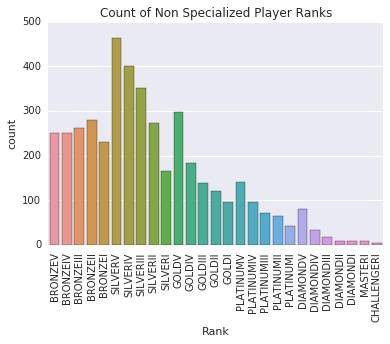

In [32]:
g = sns.countplot(nonOtpRanks, order = rankOrder)
g.set_xticklabels(labels = rankOrder, rotation=90);
plt.title('Count of Non Specialized Player Ranks');

So far the distribution of the two groups looks fairly similar, so I'll overlap the graph of their frequencies to make sure of this

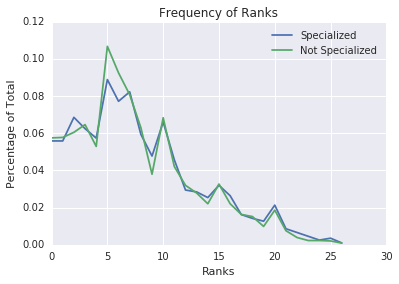

In [33]:
getFreq(otpRanks)

getFreq(nonOtpRanks)
plt.title('Frequency of Ranks')
plt.xlabel('Ranks')
plt.ylabel('Percentage of Total');
plt.legend(['Specialized', 'Not Specialized']);

It seems that overall, there is not that much of a difference between specialized and non specialized players with the exception of players in low Silver. Since there doesn't seem to be much correlation between heavily specializing in one champion and playing multiple, I'll explore correlations amongst player champion preferences give recommendations on other champions a player may enjoy.

First, I'll use interact to see correlations between two specific champions. I will need two axis to represent both Champion A and B. This is someone who plays Champion A may enjoy playing Champion B, but someone who plays Champion B may not necessarily play Champion A

In [34]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [35]:
def twoChamp(champA, champB):
    if (champA == champB):
        print('Same Champion, Illegal Argument')
    try:
        a = df2[champA][champB]
        b = df2[champB][champA]
        plt.scatter(a,b);
        plt.title('Correlation between Champ A and Champ B')
        plt.xlabel('Champ A players on Champ B')
        plt.ylabel('Champ B players on Champ A')
        plt.axis([0, 1.05, 0, 1.05])
    except KeyError:
        print('Not Enough Data')

Same Champion, Illegal Argument


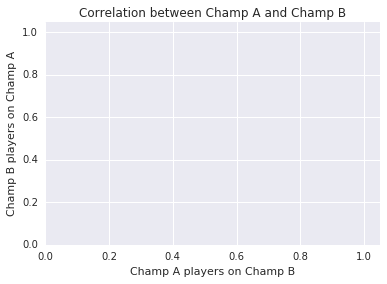

In [36]:
interact(twoChamp, champA = champColumns, champB = champIndices);

It's a bit tedious to go through each correlation if I want to see which champion has the highest correlation with another, so I'll create a barplot that displays them all at once.

In [37]:
def champPlayCount(champ):
    plt.figure(figsize = (5,25))
    plt.axhline(0, color='k');
    df2.ix[champ].plot.barh();

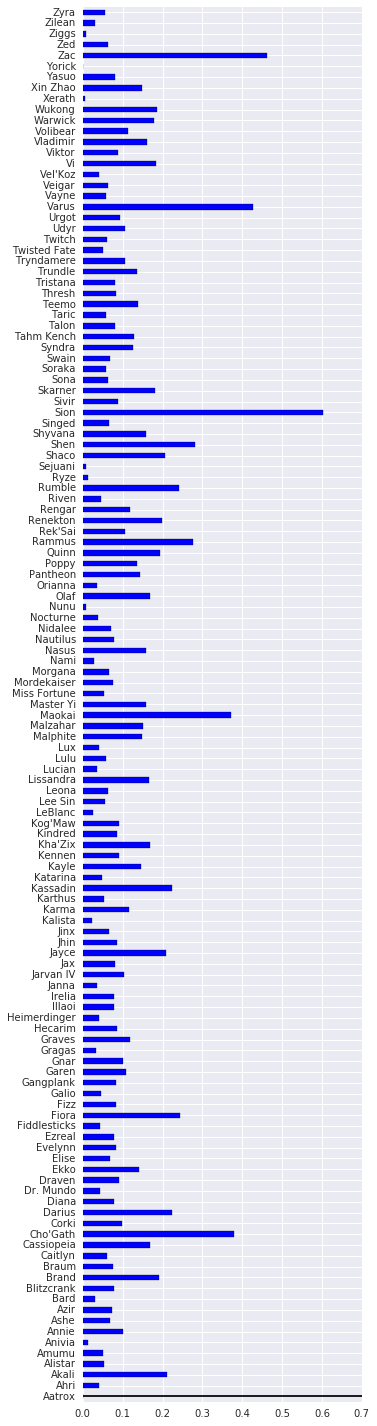

In [38]:
interact(champPlayCount, champ = champColumns);

# The Final Model

Though it's seeing correlations between champions one and a time, I want to be able to create a model that can give the viewer all of this information at once. From a look at my data, it seems to be a weighted adjacency matrix so seaborn does not really provide the tools to model this. So my solution is to use the networkx library instead.

In [39]:
import networkx as nx

Since every champion has at least a feint correlation with once another, I'll need a method to filter out only the strong correlations, being over 0.8.

In [40]:
def getLargest(champ):
    df3 = df2
    output = df3.loc[df2[champ] >= 0.8]
    return list(output.index.values)

I want to make it easy for the viewer to be able to tell the difference between a champion with many correlations versus champions with lets say just one, so I will be color coding it where red is the most, orange is moderately high, and blue to represent everything else. The solid lines on the graph will show that the correlation is very strong while the dashed lines will show that there is a weaker correlation.

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


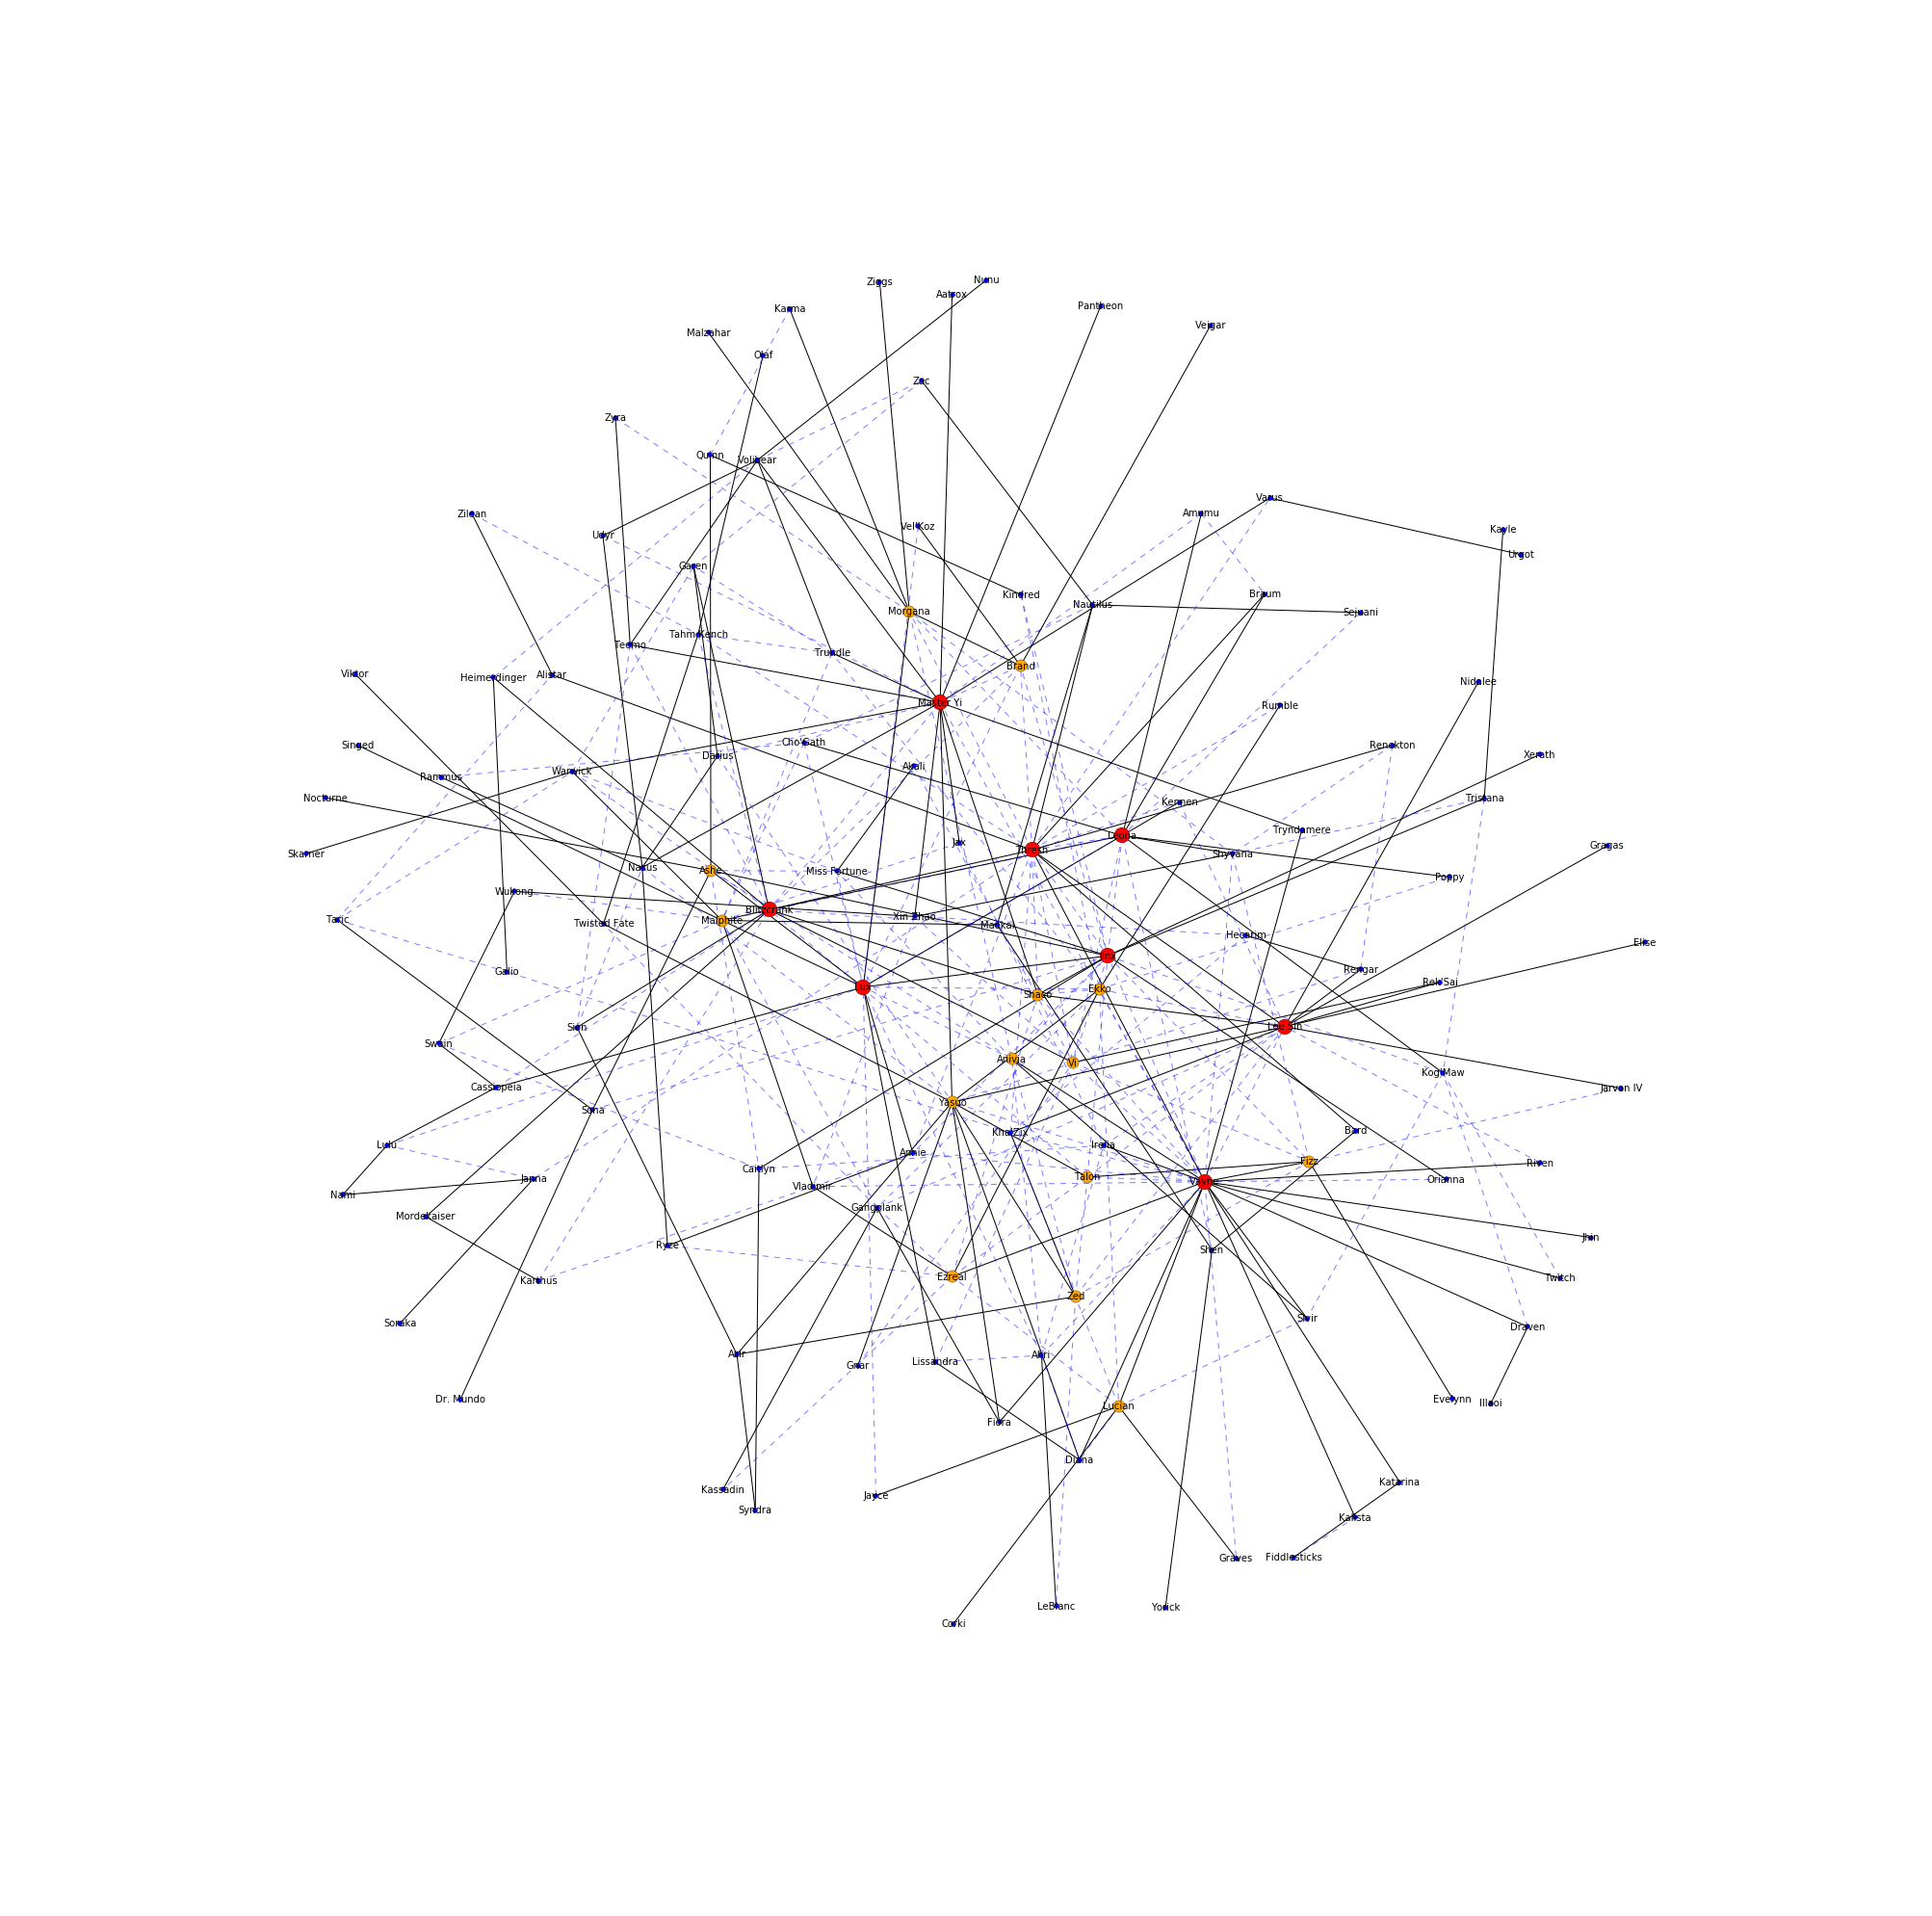

In [41]:
G=nx.Graph()

for champA in champColumns:
    champB = getLargest(champA)
    for b in champB:
        G.add_edge(champA,b, weight = df2[champA][b])


plt.figure(figsize=(35,35))    
node_color=[float(G.degree(v)) for v in G]
pos=nx.spring_layout(G) 

nx.draw_networkx_nodes(G,pos,node_size=25, nodelist = [v for v in G if G.degree(v)], node_color = 'b')
nx.draw_networkx_nodes(G,pos,node_size=150, nodelist = [v for v in G if G.degree(v) > 7], node_color = 'Orange')

nx.draw_networkx_nodes(G,pos,node_size=250, nodelist = [v for v in G if G.degree(v) >= 15], node_color = 'r')


elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.95]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.95]

nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b',style='dashed')


nx.draw_networkx_labels(G,pos,font_size=10,font_family='arial')


plt.axis('off')
plt.savefig("weighted_graph.png")
plt.show()